In [33]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [180]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

In [331]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
#     ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j + N_2_j > 0))[0]
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j))  # N_j
    
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = O_j/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = N_j/(N_1_j*N_2_j)
#     var = np.trapz((res[:, 0] * res[:, 0] * res[:, 2]), bins[ind])
#     num = np.trapz((res[:, 0] * res[:, 1]), bins[ind])
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()
    
    if var == 0:
        return 0
    stat_val = np.power(num, 2) / var
    
#     var2 = (res[::-1, 0] * res[::-1, 0] * res[:, 2]).sum()
#     num2 = (res[::-1, 0] * res[:, 1]).sum()
#     stat_val += np.power(num2, 2) / var2

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, 
                     weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)

        if weightings == 8:
            weightings = 4 
            logrank1 = lr_hist_statistic(time_hist_1.astype("float32"),
                                time_hist_2.astype("float32"),
                                cens_hist_1.astype("float32"),
                                cens_hist_2.astype("float32"),
                                np.uint32(weightings),
                                weights_hist.astype("float32")
                               ) 
            logrank2 = lr_hist_statistic(time_hist_1[::-1].astype("float32"),
                                        time_hist_2[::-1].astype("float32"),
                                        cens_hist_1[::-1].astype("float32"),
                                        cens_hist_2[::-1].astype("float32"),
                                        np.uint32(weightings),
                                        weights_hist.astype("float32")
                                       )
            return logrank1 + logrank2
        
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                            time_hist_2.astype("float32"),
                            cens_hist_1.astype("float32"),
                            cens_hist_2.astype("float32"),
                            np.uint32(weightings),
                            weights_hist.astype("float32")
                           ) 
        return logrank
    except Exception as err:
        print(err)
        return 0.0

    
def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
                              apr_t_distr, apr_e_distr, l_reg):
    none_to = 0
    max_stat_val = 1.0
    
#     n1 = np.cumsum(left_time_hist[::-1])[::-1] + 1
#     n2 = np.cumsum(right_time_hist[::-1])[::-1] + 1
#     cf = n1/(n1 + n2)
    cf = 0.5
    
#     n1 = np.sum(left_time_hist)
#     n2 = np.sum(right_time_hist)
#     cf = n1/(n1 + n2)
    
#     ev = np.sum(left_cens_hist + right_cens_hist)
#     ev_cf = ev/(n1 + n2)
#     lstd = np.std(np.repeat(np.arange(left_time_hist.size), left_time_hist.astype(int)))
#     rstd = np.std(np.repeat(np.arange(right_time_hist.size), right_time_hist.astype(int)))
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + na_cens_hist + l_reg*apr_e_distr*cf, 
                             right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + na_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + l_reg*apr_e_distr*cf,
                             right_cens_hist + na_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf,
                                        right_time_hist + l_reg*apr_t_distr*(1 - cf),
                                        left_cens_hist + l_reg*apr_e_distr*cf, 
                                        right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh, stat_diff=None):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    attrs["stat_diff"] = stat_diff 
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
#     plt.hist([v["stat_diff"] for v in attr_dicts])
#     plt.show()
    
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts)//2)]
    attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]))[:max(1, len(attr_dicts)//2)]
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
                                                                       
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        best_attr["src_val"] = best_attr['values']
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def split_time_to_bins(time, apr_times):
    if apr_times is None:
        return np.searchsorted(np.unique(time), time)
#         return np.searchsorted(np.quantile(time, np.arange(6)/5), time)
    return np.searchsorted(np.unique(apr_times), time)
#     return np.searchsorted(np.quantile(apr_times, np.arange(6)/5), time)
#     if apr_times is None:
#         return np.searchsorted(np.arange(int(time.min() - 1), int(time.max() + 1)), time)
#     return np.searchsorted(np.arange(int(apr_times.min() - 1), int(apr_times.max() + 1)), time)


def ranksums_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    s = np.dot(x, rank)
#     print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

def diptest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, diptest.dipstat(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, diptest.dipstat(t2))
    return res

def diptest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, t1.std())
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, t2.std())
    return res

def peaktest_hist(x, y):
    return max(max_width_peaks(x), max_width_peaks(y))

def mw_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    R1 = np.dot(x, rank)
    U1 = R1 - n1*(n1+1)/2
    U2 = n1 * n2 - U1

    U = np.maximum(U1, U2)
    return U

def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, 
                         apr_time=None, apr_event=None, l_reg=0, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    if np.sum(cens) == 0:
        return best_attr
    if weights is None:
        weights = np.ones_like(dur)
        
    weights_hist = None
    dur = split_time_to_bins(dur, apr_time)
    
    if apr_time is None:
        time_bins = np.unique(dur)
        max_bin = dur.max()
        apr_t_distr = np.zeros(max_bin + 1)
        apr_e_distr = np.zeros(max_bin + 1)
    else:
        time_bins = np.unique(apr_time)
        apr_time_1 = split_time_to_bins(apr_time, apr_time)
        max_bin = apr_time_1.max()
        apr_t_distr, apr_e_distr = get_sa_hists(apr_time_1, apr_event, minlength=max_bin + 1)
    
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    weights_notna = weights[~ind]

    dis_coef = 1
    if balance:
        dis_coef = (cens.shape[0] - np.sum(cens)) / np.sum(cens)

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights_notna)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)
    l_cens_hist = l_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        weights_hist = ibs_WW(y_, y_, sf, dd, axis=0)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "weights":
        weights_hist = np.bincount(dur, weights=weights,
                                   minlength=max_bin + 1)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]  # np.sqrt()

        weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    
    for u in np.unique(index_vals_bin):
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights_notna[curr_mask])
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
            
#         plt.plot(l_time_hist)
#         plt.plot(r_time_hist)
#         plt.plot(apr_t_distr)
#         plt.show()
        
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
            apr_t_distr, apr_e_distr, l_reg)
        
        if max_stat_val > signif_stat:
            if na_time_hist.shape[0] > 0:
                stat_diff = diptest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
                                         (r_time_hist + none_to*na_time_hist))
            else:
                stat_diff = diptest_hist(l_time_hist,
                                         r_time_hist)
            
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan, stat_diff)
            attr_dicts.append(attr_loc)
            
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [332]:
from survivors.tree.node import Node, Rule
from survivors.tree import CRAID

class Node1(Node):
    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}
        attr = max(attrs, key=lambda x: attrs[x]["stat_val"])
        
        return (attr, attrs[attr])
    
    def split(self):
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        
        attr, best_split = self.find_best_split()
        
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges
        if self.verbose > 0:
            print('='*6, best_split["p_value"], attr)

        branch_ind = self.ind_for_nodes(self.df[attr], best_split, attr in self.categ)

        for n_b in np.unique(branch_ind):
            rule = Rule(feature=attr,
                        condition=best_split["values"][n_b],
                        has_nan=best_split["pos_nan"][n_b])
            d_node = self.df[branch_ind == n_b].copy()
            N = Node1(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth + 1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        if self.rule_edges.shape[0] == 1:
            print(branch_ind, self.df[attr], best_split, attr in self.categ)
            raise ValueError('ERROR: Only one branch created!')

        return node_edges

class CRAID1(CRAID):
    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01
        if isinstance(self.info["min_samples_leaf"], float):
            self.info["min_samples_leaf"] = max(int(self.info["min_samples_leaf"] * X_tr.shape[0]), 1)

        cnt.set_seed(self.random_state)

        if self.balance in ["balance", "balance+correct"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()
            self.correct_proba = freq[1] / (freq[1] + freq[0])  # or freq[1] / (freq[0])

            X_tr = get_oversample(X_tr, target=cnt.CENS_NAME)
        elif self.balance in ["balance+weights"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()

            X_tr["weights_obs"] = np.where(X_tr[cnt.CENS_NAME], freq[0] / freq[1], 1)
            self.info["weights_feature"] = "weights_obs"
        elif self.balance in ["only_log_rank"]:
            self.info["balance"] = True

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node1(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

        return

In [333]:
class BootstrapCRAID1(BootstrapCRAID):
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.y_train = y
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_cr = cnt.pd_to_xy(x_sub)

            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_cr)

            self.add_model(model, x_oob)
        print(f"fitted: {len(self.models)} models.")

In [334]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]
            
            model = CRAID1(features=self.features, apr_time=y_sub_tr["time"].copy(), apr_event=y_sub_tr["cens"].copy(),
                           random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_sf = metr.auprc(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(ibs_sf)
        wei = 1 - ibs_sf
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # self.weights += wei_i
        pass

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)

In [335]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# y["time"] += 1

# # y["cens"] = ~y["cens"]
# features = list(set(features) - {"max_2019_nCoV_nucleic_acid_detection", 
#                                  "mean_2019_nCoV_nucleic_acid_detection", 
#                                  "min_2019_nCoV_nucleic_acid_detection"})
# X = X[features]

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['min_' + c] = df_agg[c].apply(np.nanmin)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['max_

In [336]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}


bstr = BootstrapCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.1456 0.1351 0.1155 0.1087 0.0995 0.0962 0.0963 0.094  0.093  0.0915
 0.0904 0.0881 0.0873 0.0854 0.0838 0.084  0.0842 0.0851 0.0843 0.0837
 0.0833 0.0826 0.0825 0.0827 0.0815 0.0818 0.0812 0.0806 0.0808 0.0807
 0.0799 0.0793 0.0789 0.0787 0.0782 0.078  0.0782 0.0778 0.0779 0.0775
 0.0774 0.0776 0.0767 0.077  0.0767 0.0768 0.0767 0.0767 0.0763 0.0761]
fitted: 50 models.
[0.75867032 0.07254859 0.1335381  0.84727707 0.7503295  0.53066127
 0.73701628]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
 0.73447933]

In [ ]:
[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298]

In [ ]:
[0.61622044 0.14232877 0.36427644 0.76000316 0.68964637 0.5158604
 0.66995968]

In [ ]:
[0.76662097 0.07352715 0.1427046  0.85226585 0.74681081 0.52533867
 0.73338826]

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
 0.73447933]

In [ ]:
[0.76031528 0.07545675 0.13330532 0.84776847 0.74616391 0.52064969
 0.73249638]

In [ ]:
[0.75222755 0.07254517 0.14051689 0.87888129 0.74781346 0.53118041
 0.73468419]
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]
[0.62798515 0.14223849 0.34295473 0.76877587 0.6948715  0.51542966
 0.67454411]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62778972 0.14300061 0.33354884 0.77477676 0.69121148 0.50949231
 0.6706261 ]

In [ ]:
[0.6281024  0.14091349 0.34395037 0.77027241 0.69435691 0.52027288
 0.67463645]

In [ ]:
[0.62614813 0.14374146 0.34480665 0.75541951 0.69278564 0.51871816
 0.67306706]

In [ ]:
[0.63091655 0.1422004  0.34096467 0.76252518 0.69420142 0.52163777
 0.67465319]

In [ ]:
[0.63162009 0.14071645 0.34137235 0.76280546 0.69149669 0.51923545
 0.67198272]

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_23760\1053756791.py:5: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))


Text(0, 0.5, 'Mean leaf time')

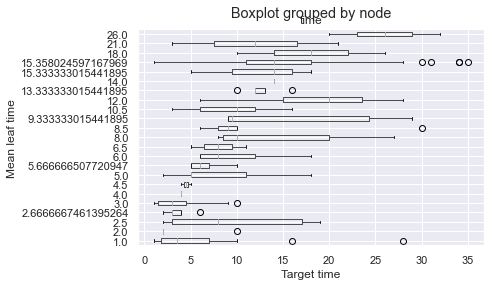

In [329]:
ind = 0
pred_0_numb = bstr.models[ind].predict(X_tr, target="numb")
pred_0_time = bstr.models[ind].predict(X_tr, target="time")

a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))

dd_ = pd.DataFrame()
dd_["time"] = y_tr["time"]
dd_["node"] = pred_0_time
ax = dd_.boxplot(column='time', by='node', vert=False)
# ax.set_yticks(np.unique(pred_0_numb[~pd.isna(pred_0_numb)]))

# plt.scatter(y_tr["time"], pred_0_time, c=pred_0_numb)
# plt.hlines(y=[a], xmin=y_tr["time"].min(), xmax=y_tr["time"].max(), alpha=0.3)
plt.xlabel("Target time")
plt.ylabel("Mean leaf time")

In [322]:
np.unique(pred_0_numb)

array([ 4.,  8., 10., 12., 14., 15., 20., 28., 30., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 46., 47., 48., 52., 53.,
       55., 56., 57., 58.])

corr: -0.16206358011413108
p-value: 0.08924932373108184


C:\Users\vasiliev\AppData\Local\Temp\ipykernel_23760\3754810174.py:14: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))


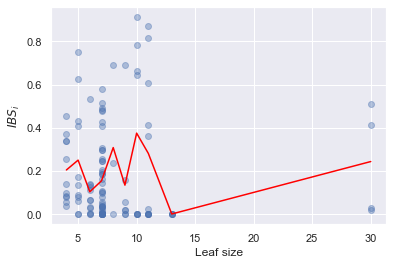

In [212]:
from scipy.stats import spearmanr

X_ = X_HO.reset_index(drop=True)

ind = 0
X_sub = X_.loc[X_.index.difference(bstr.oob_index[ind]), :]
y_sub = y_tr[X_.index.difference(bstr.oob_index[ind])]

pred_0_time = bstr.models[ind].predict(X_sub, target="time")
pred_0_size = bstr.models[ind].predict(X_sub, target="size")
pred_0_surv = bstr.models[ind].predict_at_times(X_sub, bins=bins_HO, mode="surv")

ibss = metr.ibs_WW(y_tr, y_sub, pred_0_surv, bins_HO, axis=0)
a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))

plt.scatter(pred_0_size, ibss, alpha=0.4)
plt.plot(np.unique(pred_0_size), a[~np.isnan(a)], color="red")
plt.xlabel("Leaf size")
plt.ylabel(r"$IBS_i$")

rho, p = spearmanr(ibss[pred_0_size < 30], pred_0_size[pred_0_size < 30])
print("corr:", rho)
print("p-value:", p)

In [24]:
1/y_tr.shape[0]

0.00398406374501992

In [213]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'aggreg_func': 'mean', 'all_weight': True, 'balance': None, 
              'categ': categ, "l_reg": 0.01,
              'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
              'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
              'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr = IBSCleverBoostingCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

UNIQUE (0):231, DIST: [189 132]
[0.03453786351857184, 0.03459358455309873, 0.03469733949559467, 0.035237955346651, 0.03560998867632159, 0.035827389823291464, 0.035866968033580894, 0.03638411886493728, 0.03723768018773048, 0.03970998406193079, 0.03977605386416862, 0.04036329322953527, 0.04064706234294604, 0.04149789621318372, 0.0415570712013702, 0.04184165232358003, 0.04217265875323549, 0.04218672379533035, 0.04218995290423862, 0.042227360600432126, 0.042268433881779394, 0.042722647291229016, 0.043004955926304246, 0.04335114426857547, 0.043725966084599374, 0.043770314192849415, 0.04404384455113688, 0.04449308829660989, 0.04506619551274294, 0.045354008991981214, 0.04543533389687237, 0.04623674604554146, 0.04639847512038523, 0.04645128340307753]
[0.03453786351857184, 0.03459358455309873, 0.03469733949559467, 0.035237955346651, 0.03560998867632159, 0.035827389823291464, 0.035866968033580894, 0.03638411886493728, 0.03723768018773048, 0.03970998406193079, 0.03977605386416862, 0.0403632932295

[0.11823899371069183]
[0.11823899371069183]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
[0.25]
[0.25]
[0.19384615384615386]
[0.19384615384615386]
[0.1111111111111111, 0.125]
[0.125, 0.125, 0.125]
[0.125, 0.125, 0.125]
[0.125]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285]
[0.16666666666666666]
[0.2]
[0.13145351174409925, 0.14129629629629628, 0.14285714285714285]
[0.13145351174409925, 0.14129629629629628, 0.14285714285714285]
[0.2]
[0.2]
[0.2448700410396717]
[0.1, 0.10029717682020803, 0.1111111111111111, 0.11283432392273403, 0.11475761475761476, 0.125]
[0.1, 0.10029717682020803, 0.1111111111111111, 0.11283432392273403, 0.11475761475761476, 0.125]
[0.16666666666666666, 0.1875]
[0.2]
[0.2]
[0.12728995578016425]
[0.125]
[0.125]
[0.1340042372881356]
[0.125]
[0.125]
UNIQUE (1):237, DIST: [181 140]
[0.033501324546100684, 0.034178552562070794, 0.03909379052009799, 0.039896720737542316, 0.03996029703698256, 0.0

[0.1206260185984086, 0.125, 0.13481731490410373, 0.14133709981167608, 0.15110807528840317]
[0.125]
[0.25]
[0.125, 0.14285714285714285]
[0.125, 0.14285714285714285]
[0.2]
[0.2]
[0.2]
[0.16666666666666666, 0.17234367056431113]
[0.16666666666666666, 0.17234367056431113]
[0.1312021312021312, 0.15734265734265734]
[0.1570408532176428]
[0.1570408532176428]
[0.19230769230769232]
[0.19230769230769232]
[0.2037962037962038]
[0.2037962037962038]
[0.15694164989939638]
[0.2, 0.2072599531615925]
[0.2, 0.2072599531615925]
[0.125]
UNIQUE (2):230, DIST: [181 140]
[0.055716997492442195]
[0.055716997492442195]
[0.03540746927574275, 0.036845983787767135, 0.03710728829568152, 0.03762525997352996, 0.037917087967644085, 0.038744186046511635, 0.03923429837051099, 0.040849199720456135, 0.042049025769956, 0.042321589882565486, 0.04237205492276486, 0.04279264542301904, 0.04337772376660421, 0.04419140697031163, 0.045388115720596554, 0.04576036339742308, 0.04615813080824368, 0.046535855721598976, 0.0581573212639342

[0.10714285714285714]
[0.10714285714285714]
[0.13775510204081634]
[0.1, 0.100187265917603]
[0.1, 0.100187265917603]
[0.09284332688588007]
[0.125, 0.15710851648351648]
[0.125, 0.15710851648351648]
[0.125, 0.125]
[0.125, 0.125]
[0.125]
[0.125]
[0.125]
[0.07554347826086956, 0.07638888888888888, 0.07897727272727272, 0.08621651785714286, 0.08725445408862495, 0.08814102564102563, 0.09090909090909091, 0.09196428571428572, 0.09597989949748745, 0.09872448979591837, 0.1]
[0.125]
[0.16666666666666666]
[0.08333333333333333]
[0.08333333333333333]
[0.14002828854314003]
[0.12273347631117178, 0.12800245098039215, 0.12831227068895232, 0.13558794220229198]
[0.2]
[0.2]
[0.125]
[0.14127423822714683]
[0.14127423822714683]
[0.11855417754569192, 0.1222793826671943]
[0.17636986301369864]
[0.17636986301369864]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
[0.1748492678725237]
[0.1748492678725237]
[0.17606244579358196]
[0.125]
[0.125]
[0.16666666666666666]
[0.08289930555555555, 0.08333333333

[0.08949248990934956, 0.09508577052868392, 0.1, 0.10866945203278162]
[0.08949248990934956, 0.09508577052868392, 0.1, 0.10866945203278162]
[0.09917570951585977]
[0.10302153648344584]
[0.10302153648344584]
[0.125]
[0.125]
[0.1, 0.11844919786096257, 0.12310866574965611, 0.125]
[0.1, 0.11844919786096257, 0.12310866574965611, 0.125]
[0.14285714285714285]
[0.14285714285714285]
[0.08427755819060168]
[0.06802168021680217, 0.06911161128028598, 0.06956762749445676, 0.07118547929665343, 0.07142857142857142, 0.07177904400126624, 0.07185185185185186, 0.07313336558619578, 0.0736918907650615, 0.07503918495297807, 0.07767523621182158, 0.0804093567251462]
[0.06802168021680217, 0.06911161128028598, 0.06956762749445676, 0.07118547929665343, 0.07142857142857142, 0.07177904400126624, 0.07185185185185186, 0.07313336558619578, 0.0736918907650615, 0.07503918495297807, 0.07767523621182158, 0.0804093567251462]
[0.07758620689655173]
[0.1, 0.1194240542066629]
[0.1, 0.1194240542066629]
[0.18495934959349591]
[0.184

[0.1, 0.125, 0.1250585480093677, 0.13636363636363635]
[0.1, 0.125, 0.1250585480093677, 0.13636363636363635]
[0.125, 0.125, 0.125]
[0.083105147864184, 0.12491822777282187, 0.125]
[0.083105147864184, 0.12491822777282187, 0.125]
[0.12499999999999999]
[0.13211077844311378]
[0.1321492007104796]
[0.07333333333333333, 0.1, 0.1111111111111111]
[0.125, 0.14964633068081343]
[0.125, 0.14964633068081343]
[0.15574596774193547, 0.16666666666666666]
[0.15203936688311687]
[0.15203936688311687]
[0.15288232963549922]
[0.125, 0.1498881431767338]
[0.125, 0.1498881431767338]
[0.20853307766059445]
[0.25]
[0.25]
[0.16666666666666666]
[0.10004524886877827, 0.13943569553805774]
[0.10004524886877827, 0.13943569553805774]
[0.08676160337552742, 0.09629315659679408, 0.1, 0.10560053981106612, 0.1111111111111111, 0.11146723646723647, 0.11851465427297733, 0.1243462869096468]
[0.08333333333333333, 0.1, 0.1111111111111111]
[0.08333333333333333, 0.1, 0.1111111111111111]
[0.08614457831325302]
[0.16311754684838162]
[0.163

[0.125, 0.13963161021984552]
[0.125, 0.125]
[0.125, 0.125]
[0.125]
[0.125]
[0.125]
[0.125, 0.14285714285714285]
[0.15872078305628218]
[0.15872078305628218]
[0.1111111111111111, 0.125]
[0.1641566265060241]
[0.1641566265060241]
[0.15779049295774647]
[0.1019786910197869, 0.12237442922374428]
[0.1019786910197869, 0.12237442922374428]
[0.125]
[0.11372321945570354]
[0.11372321945570354]
[0.053072625698324015, 0.055171568627450984, 0.055845915602013164, 0.056289148467919416, 0.058048184357541895, 0.05877897288289653, 0.061, 0.06191806331471136, 0.0619639794168096, 0.06634078212290502, 0.0670533369910256, 0.06777647767967947, 0.07149666348903717, 0.07430167597765362, 0.0773975791433892, 0.07829885057471264, 0.0807626912800583, 0.08168393782383418, 0.08329559178743962, 0.08389162561576355]
[0.06817367415193501, 0.06867283950617284, 0.07131410256410256, 0.07416666666666666, 0.07692307692307691, 0.08025258323765787, 0.08026755852842808, 0.08098001289490651, 0.0839160839160839, 0.08428030303030302

[0.06403235451483964, 0.06507484285262063, 0.06666666666666667, 0.06832858499525167, 0.07142857142857142, 0.07391608391608392, 0.07894736842105263, 0.08571428571428572, 0.08703878902554399, 0.08875605326876514, 0.09375]
[0.05961809699468374, 0.06554185593770279, 0.06653491436100131, 0.06686046511627906, 0.06970324361628709, 0.07082748948106592, 0.0724551389972488, 0.07282490932215366, 0.07318840579710145, 0.0744744558708132, 0.075165523052847, 0.07571214392803598, 0.0763888888888889, 0.08024396077493423, 0.08132045088566828, 0.08176016622143069, 0.08231387227826721, 0.08277657397375708, 0.08383072614636078, 0.08514161894443585, 0.08711820560308081, 0.08731231000706237, 0.08764578420750749, 0.08906655309922955, 0.09067405072973718, 0.09453252097355577, 0.09754908196582283, 0.10097792013084367]
[0.125]
[0.12806861875184858]
[0.14285714285714285]
[0.16666666666666666]
[0.16666666666666666]
[0.15360000000000001]
[0.15360000000000001]
[0.09090909090909091, 0.0997340425531915, 0.102291325695

[0.13636363636363635, 0.1605917667238422]
[0.13636363636363635, 0.1605917667238422]
[0.13636363636363635, 0.14721254355400698]
[0.09016497731031849, 0.09090909090909091, 0.09716626376578029, 0.1]
[0.09016497731031849, 0.09090909090909091, 0.09716626376578029, 0.1]
[0.09090909090909091, 0.09200953069820873, 0.1, 0.10011031439602869]
[0.1111111111111111, 0.125, 0.14285714285714285, 0.16331031837360951]
[0.1111111111111111, 0.125, 0.14285714285714285, 0.16331031837360951]
[0.1111111111111111]
[0.125, 0.1433142857142857]
[0.16666666666666666]
[0.16666666666666666]
[0.2]
[0.14285714285714285]
[0.125, 0.125, 0.13477664278091173, 0.14285714285714285]
[0.1504988913525499, 0.16666666666666666]
[0.1504988913525499, 0.16666666666666666]
[0.2]
[0.2]
[0.2]
[0.20384615384615384]
[0.20384615384615384]
[0.18142857142857144]
[0.125]
[0.125]
[0.2249128919860627]
[0.2249128919860627]
[0.14721254355400698]
[0.10714285714285714, 0.11538461538461539, 0.12797619047619047]
[0.10714285714285714, 0.115384615384

[0.125]
[0.125]
[0.14521452145214522]
[0.1111111111111111, 0.11783667621776504]
[0.1111111111111111, 0.11783667621776504]
[0.1179245283018868, 0.11952380952380953]
[0.2]
[0.2]
[0.11193324937027709, 0.12210899931302954, 0.125, 0.12832621550591328, 0.130394611349547, 0.1343198992443325]
[0.11193324937027709, 0.12210899931302954, 0.125, 0.12832621550591328, 0.130394611349547, 0.1343198992443325]
[0.08333333333333333, 0.1, 0.10795960795960798]
[0.25]
[0.25]
[0.15499334221038616]
[0.15499334221038616]
[0.16666666666666666]
[0.14390034364261167]
[0.14390034364261167]
[0.125, 0.133125]
[0.10220125786163521, 0.10965171192443919, 0.12499999999999997]
[0.10220125786163521, 0.10965171192443919, 0.12499999999999997]
[0.13948170731707318]
[0.20454545454545453]
[0.20454545454545453]
UNIQUE (9):231, DIST: [183 138]
[0.03968022145428237, 0.04162783473128298, 0.041830762250453735, 0.04224241669778829, 0.04254901163814712, 0.042686555321934376, 0.043349091583240636, 0.043601248536870855, 0.0436458037561

[0.125, 0.1425190765961557, 0.14285714285714285, 0.14497330960854093, 0.14548670247609066]
[0.125, 0.12581699346405228, 0.12956487956487958, 0.13718298050723116, 0.14285714285714285]
[0.2]
[0.2]
[0.2]
[0.25]
[0.25]
[0.14285714285714285, 0.14411764705882352, 0.1459832134292566, 0.16666666666666666]
[0.14285714285714285, 0.14411764705882352, 0.1459832134292566, 0.16666666666666666]
[0.125, 0.125, 0.1326905417814509, 0.14595959595959598]
[0.2]
[0.2]
[0.24657869012707723]
[0.1320824135393672]
[0.1320824135393672]
[0.1, 0.11652739090064995]
[0.15642857142857142]
[0.12668566001899334, 0.14252136752136751, 0.14285714285714285]
[0.12668566001899334, 0.14252136752136751, 0.14285714285714285]
[0.1, 0.1498884257504947, 0.155184331797235]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
[0.15958646616541353]
[0.15958646616541353]
[0.15958646616541353]
UNIQUE (10):224, DIST: [185 136]
[0.0388385554297219]
[0.0388385554297219]
[0.033657513348588866, 0.034258540

[0.10018115942028985]
[0.10018115942028985]
[0.15384615384615385, 0.16666666666666666, 0.18181818181818182]
[0.12790697674418605]
[0.14285714285714285]
[0.14285714285714285]
[0.2]
[0.2]
[0.125]
[0.2]
[0.2]
[0.16889763779527558]
[0.13052884615384613, 0.14917582417582415]
[0.2]
[0.125]
[0.125]
[0.12612903225806452]
[0.09237875288683602]
[0.09237875288683602]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285, 0.16666666666666666]
[0.06213704994192799, 0.06339973825796132, 0.0653245304072903, 0.0662815445424141, 0.0689536709854731, 0.07300976927873623, 0.07465256918579039, 0.07602611940298508, 0.07757287985865724, 0.08109452736318408, 0.0846775928076741]
[0.06213704994192799, 0.06339973825796132, 0.0653245304072903, 0.0662815445424141, 0.0689536709854731, 0.07300976927873623, 0.07465256918579039, 0.07602611940298508, 0.07757287985865724, 0.08109452736318408, 0.0846775928076741]
[0.08327825512227362]
[0.08400974025974026, 0.08499688084840921, 0.09916302765647743, 0.1033966033

[0.20442826812253564]
[0.20442826812253564]
[0.11538461538461539]
[0.14285714285714285]
[0.14285714285714285]
[0.11366796440489434, 0.12331161608136024]
[0.25]
[0.125]
[0.125]
[0.2]
[0.2]
[0.2]
[0.125]
[0.125]
[0.1875]
[0.125]
[0.125]
[0.19999999999999998]
[0.12035976168652612, 0.125]
[0.12035976168652612, 0.125]
[0.2]
[0.08455531711969481]
[0.08455531711969481]
[0.07142857142857142, 0.07771205638056884, 0.08003312211981568, 0.08048748696558916, 0.08144329896907215, 0.08270089285714287, 0.08333333333333333, 0.08346850500135172, 0.08888604353393088, 0.09090909090909091, 0.09523809523809523, 0.09635416666666667]
[0.09883970777825526, 0.1, 0.1123325190613665, 0.125]
[0.09883970777825526, 0.1, 0.1123325190613665, 0.125]
[0.11716101694915254, 0.11936936936936937]
[0.125]
[0.125]
[0.09069920844327177, 0.09555555555555556, 0.09894459102902374, 0.1, 0.1]
[0.14285714285714285, 0.16666666666666666, 0.16666666666666666]
[0.14285714285714285, 0.16666666666666666, 0.16666666666666666]
[0.125]
[0.17

[0.25]
[0.25]
UNIQUE (13):236, DIST: [187 134]
[0.04208504743514399, 0.043300083125519535, 0.04342747929496708, 0.04547994740302432, 0.04683565617370409, 0.04720769174095629, 0.0479790636813027, 0.048711365985396576, 0.049473604626986974, 0.04990925589836661, 0.051181009739801456, 0.051214574898785434, 0.05151128139633887, 0.0530059772032249, 0.056764323567643236, 0.05981654391153898, 0.060698072933890505, 0.06243683323975296, 0.0652473007951869, 0.0695536540240518, 0.07046957931341019]
[0.04208504743514399, 0.043300083125519535, 0.04342747929496708, 0.04547994740302432, 0.04683565617370409, 0.04720769174095629, 0.0479790636813027, 0.048711365985396576, 0.049473604626986974, 0.04990925589836661, 0.051181009739801456, 0.051214574898785434, 0.05151128139633887, 0.0530059772032249, 0.056764323567643236, 0.05981654391153898, 0.060698072933890505, 0.06243683323975296, 0.0652473007951869, 0.0695536540240518, 0.07046957931341019]
[0.05716789344549597]
[0.08793127147766322, 0.08948863636363637

[0.09691833590138675, 0.1, 0.10412616115791747, 0.10707630878438333, 0.1111111111111111, 0.11683997689196995]
[0.09691833590138675, 0.1, 0.10412616115791747, 0.10707630878438333, 0.1111111111111111, 0.11683997689196995]
[0.09628817413905134]
[0.08246753246753248, 0.08333333333333333, 0.1, 0.11334804191947048]
[0.08246753246753248, 0.08333333333333333, 0.1, 0.11334804191947048]
[0.14926470588235294]
[0.125]
[0.125]
[0.09200114405567739, 0.09318637274549099, 0.09375, 0.09980582524271844, 0.1, 0.10181228819802564, 0.1044587596311734, 0.10606060606060606, 0.10714285714285714, 0.10872977953723294]
[0.09200114405567739, 0.09318637274549099, 0.09375, 0.09980582524271844, 0.1, 0.10181228819802564, 0.1044587596311734, 0.10606060606060606, 0.10714285714285714, 0.10872977953723294]
[0.09590973201692525, 0.1, 0.10756340579710144]
[0.09073724007561437, 0.09187500000000001, 0.09526699029126214, 0.09885281913595313, 0.10491803278688525, 0.10808823529411767]
[0.09073724007561437, 0.09187500000000001, 

[0.16666666666666666]
[0.16666666666666666]
[0.1111111111111111, 0.11357024106400665, 0.125, 0.125, 0.12664432861752295]
[0.125]
[0.12526205450733752, 0.12620849096258932, 0.14403748920952028, 0.14560701353154182, 0.14567809239940388, 0.14716975528629128]
[0.125]
[0.125]
[0.10502283105022832, 0.12490157480314959, 0.1295846645367412]
[0.10502283105022832, 0.12490157480314959, 0.1295846645367412]
[0.10319971870604781, 0.1111111111111111, 0.1125]
[0.1918686473807662]
[0.1918686473807662]
[0.16666666666666666]
[0.25]
[0.25]
[0.25]
[0.15904198062432723]
[0.15904198062432723]
[0.125]
[0.14285714285714285]
[0.19999999999999998]
[0.19999999999999998]
[0.12918609580330648]
[0.12918609580330648]
[0.09090909090909091]
[0.25]
[0.25]
[0.25]
[0.14111498257839722, 0.14285714285714285]
[0.14851390220517738, 0.1530398322851153]
[0.14851390220517738, 0.1530398322851153]
[0.1614414996767938]
[0.1227236737925574, 0.125, 0.125]
[0.1227236737925574, 0.125, 0.125]
[0.13228346456692913]
[0.125]
[0.125]
[0.144

[0.16484751203852327]
[0.125]
[0.08808290155440414, 0.1, 0.1001727115716753, 0.11018998272884284, 0.1147812320092113, 0.11658031088082903, 0.12243331414315871]
[0.08808290155440414, 0.1, 0.1001727115716753, 0.11018998272884284, 0.1147812320092113, 0.11658031088082903, 0.12243331414315871]
[0.12691428571428573, 0.13867395944503735, 0.1422297019949101]
[0.16666666666666666]
[0.2]
[0.2]
[0.2]
[0.125, 0.14285714285714285]
UNIQUE (16):236, DIST: [181 140]
[0.03826039086154693]
[0.03826039086154693]
[0.03362709804104914]
[0.03983168730004173, 0.04872303496156707, 0.04885639458751636, 0.056509695290858725, 0.06415564619124131, 0.08333333333333333, 0.08519894691636948, 0.1]
[0.03983168730004173, 0.04872303496156707, 0.04885639458751636, 0.056509695290858725, 0.06415564619124131, 0.08333333333333333, 0.08519894691636948, 0.1]
[0.03609415867480383, 0.03676372030679871, 0.036840484832771574, 0.03995327102803738, 0.04015827338129497, 0.04030970917553028, 0.04053263096283288, 0.04061655343706626, 0

[0.09376382131800089, 0.1, 0.1028225806451613, 0.11025641025641025, 0.11678709460594856]
[0.09376382131800089, 0.1, 0.1028225806451613, 0.11025641025641025, 0.11678709460594856]
[0.09375, 0.09579116835326587, 0.1, 0.11018328497629325]
[0.15437499999999998]
[0.15437499999999998]
[0.2]
[0.09280898876404495, 0.09337084578864076, 0.10546475995914198, 0.11048689138576778, 0.11601123595505618, 0.11706349206349206]
[0.09280898876404495, 0.09337084578864076, 0.10546475995914198, 0.11048689138576778, 0.11601123595505618, 0.11706349206349206]
[0.14724919093851133]
[0.0822450248756219]
[0.0822450248756219]
[0.07703866960528952, 0.07960662525879918, 0.08055587590819975, 0.08733164983164983]
[0.16666666666666666]
[0.16666666666666666]
[0.17491369390103567]
[0.17491369390103567]
[0.14081632653061224]
[0.14081632653061224]
[0.14285714285714285]
[0.1323529411764706]
[0.1323529411764706]
[0.10740740740740742]
[0.10194174757281552, 0.1111111111111111, 0.11468446601941745]
[0.10194174757281552, 0.1111111

[0.14285714285714285, 0.16666666666666666]
[0.10922475961538461, 0.1111111111111111, 0.11269902167657778, 0.125, 0.125, 0.125, 0.13318975289050103]
[0.08823529411764705, 0.09374999999999999, 0.0985405347821455, 0.09877326565143824, 0.09999999999999999, 0.10049452490286118, 0.1042549095109742, 0.1092841163310962]
[0.125]
[0.125]
[0.1, 0.11265969802555169]
[0.15064882400648824]
[0.15064882400648824]
[0.17514204545454545]
[0.125]
[0.141003301540719]
[0.141003301540719]
[0.25]
[0.125]
[0.125]
[0.1]
[0.135031847133758]
[0.10051282051282051, 0.1111111111111111, 0.125]
[0.10051282051282051, 0.1111111111111111, 0.125]
[0.10560578661844486, 0.11059907834101383, 0.125]
[0.10560578661844486, 0.11059907834101383, 0.125]
[0.1]
[0.1]
[0.16322314049586778]
[0.12797319932998324]
[0.12797319932998324]
[0.25]
[0.25]
[0.14285714285714285]
[0.1883535660091047]
[0.1883535660091047]
[0.2]
[0.16666666666666666]
[0.13040657439446365, 0.16666666666666666]
[0.13040657439446365, 0.16666666666666666]
[0.125, 0.14

[0.1509433962264151]
[0.1509433962264151]
[0.125]
[0.10192307692307692]
[0.10192307692307692]
[0.14285714285714285]
[0.23591212989493793]
[0.23591212989493793]
[0.14285714285714285]
[0.14285714285714285]
[0.12027833001988071, 0.125, 0.13595505617977527, 0.13953488372093023]
[0.15193274397642573, 0.1643118785975929, 0.16666666666666666]
[0.19386942675159236]
[0.19386942675159236]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
UNIQUE (19):230, DIST: [194 127]
[0.04274134119380988, 0.04459823144944252, 0.04486764425823652, 0.04503224815724816, 0.045608108108108114, 0.047204620197320926, 0.04907205516961615, 0.049291630340017434, 0.050008091924259604, 0.05202153372885081, 0.05381780381780383, 0.0548267743020518, 0.05507314036725802, 0.05517608763856934, 0.05557862679955704, 0.058431952662721894, 0.060565870910698504, 0.06260237510237512, 0.06693306693306693, 0.06758241758241756]
[0.04274134119380988, 0.04459823144944252, 0.04486764425823652, 0.04503224815724816, 0.045608

[0.14285714285714285]
UNIQUE (20):239, DIST: [186 135]
[0.03088512241054614, 0.035086071987480434, 0.035728006146753734, 0.03621651109225359, 0.037811789159934106, 0.043658326143226914, 0.052024866785079914]
[0.03088512241054614, 0.035086071987480434, 0.035728006146753734, 0.03621651109225359, 0.037811789159934106, 0.043658326143226914, 0.052024866785079914]
[0.03322169403630078, 0.034380590339892665, 0.03451001053740779, 0.03621700879765396, 0.03679150433580495, 0.03720707197064465, 0.03742424242424243, 0.0377750103777501, 0.03783277332644094, 0.03798865069356872, 0.03811456153090428, 0.038461538461538464, 0.03862179487179487, 0.038934698763133394, 0.03896103896103897, 0.03906133117426009, 0.039246193779504855, 0.03959737938168652, 0.03961631470910778, 0.03963207605407742, 0.0399558212058212, 0.04010803046104803, 0.040197846404605435, 0.040276586620926244, 0.040418267178830555, 0.040507817905078174, 0.040686421074165584, 0.04092280613527785, 0.04097379692617787, 0.0410394511149228, 0.

[0.095733574610245, 0.1, 0.1017954208532367, 0.1037121745249824, 0.125]
[0.11726457399103138]
[0.2]
[0.2]
[0.1516544117647059, 0.16666666666666666]
[0.21741499564080208]
[0.21741499564080208]
[0.08333333333333333, 0.0950087915601023, 0.09871555831779573, 0.10104166666666665, 0.10557093621108536, 0.10993668300653596, 0.11022727272727272, 0.1111111111111111, 0.11330457290767904]
[0.08333333333333333, 0.0950087915601023, 0.09871555831779573, 0.10104166666666665, 0.10557093621108536, 0.10993668300653596, 0.11022727272727272, 0.1111111111111111, 0.11330457290767904]
[0.09329307056579784]
[0.13395493395493396]
[0.13395493395493396]
[0.1, 0.1, 0.1]
[0.13919925512104284]
[0.11893939393939394]
[0.11893939393939394]
[0.08680917622523462, 0.09348680516563729, 0.09722222222222221, 0.1, 0.1, 0.10127737226277372, 0.10790513833992095]
[0.1111111111111111, 0.11538461538461539, 0.1239406779661017, 0.125, 0.125]
[0.1111111111111111, 0.11538461538461539, 0.1239406779661017, 0.125, 0.125]
[0.1090342679127

[0.11205673758865249]
[0.11205673758865249]
[0.10991044776119403, 0.1111111111111111, 0.11449004975124379]
[0.125]
[0.125]
[0.1]
[0.15434782608695652]
[0.15434782608695652]
[0.125, 0.12659489633173843, 0.13928497623475924]
[0.11177457229117743]
[0.11177457229117743]
[0.09375]
[0.10343949044585987]
[0.10343949044585987]
[0.10670364118639981, 0.1123110151187905]
[0.10670364118639981, 0.1123110151187905]
[0.11102614015572859, 0.11407563025210085, 0.11842788283277716, 0.1192794547224927, 0.125, 0.125, 0.1302565586419753]
[0.08333333333333333]
[0.08333333333333333]
[0.08333333333333333, 0.09090909090909091, 0.1, 0.1, 0.1111111111111111]
[0.16666666666666666]
[0.17556770395290158]
[0.17556770395290158]
[0.15]
[0.14818652849740932]
[0.14818652849740932]
[0.1337979094076655]
[0.161375]
[0.161375]
[0.125, 0.14285714285714285]
[0.10773584905660379]
[0.10773584905660379]
[0.1, 0.12071269487750555]
[0.12341463414634145, 0.125, 0.12576804915514597, 0.1424581005586592]
[0.12341463414634145, 0.125, 0

[0.08564526754995976, 0.08882068452380953, 0.09267007593367427, 0.09326171875, 0.09782608695652174, 0.1017037552155772, 0.10254860013022044, 0.10597826086956523, 0.11514762516046213, 0.11914724048615263]
[0.09484563055991627, 0.09491059147180193, 0.09645909645909646, 0.09737484737484738, 0.1, 0.10168991943407349, 0.10951222092900223, 0.11065323565323565, 0.11336254107338445, 0.11863823933975241]
[0.15752351097178682]
[0.15752351097178682]
[0.1111111111111111, 0.11538461538461539, 0.125]
[0.09786388474913066, 0.09849690539345711, 0.1, 0.10011344299489507, 0.10044047583375783, 0.10455433034688721, 0.10467706013363028, 0.10741808157383623, 0.10779816513761468, 0.11026541764246682, 0.1111111111111111, 0.11215399300031816]
[0.09786388474913066, 0.09849690539345711, 0.1, 0.10011344299489507, 0.10044047583375783, 0.10455433034688721, 0.10467706013363028, 0.10741808157383623, 0.10779816513761468, 0.11026541764246682, 0.1111111111111111, 0.11215399300031816]
[0.1155813953488372]
[0.144750254841

[0.125, 0.125, 0.1296796796796797, 0.14112267423525704]
[0.125, 0.125, 0.1296796796796797, 0.14112267423525704]
[0.125]
[0.1, 0.1111111111111111]
[0.1, 0.1111111111111111]
[0.15507246376811593]
[0.16666666666666666]
[0.16666666666666666]
[0.08407325194228635, 0.08910306845003933, 0.08980077311923877, 0.09375, 0.097656691134952, 0.10822866533630708, 0.11538461538461539]
[0.08407325194228635, 0.08910306845003933, 0.08980077311923877, 0.09375, 0.097656691134952, 0.10822866533630708, 0.11538461538461539]
[0.10159176029962547, 0.10174171622769754, 0.1022238425082027, 0.10471622701838529, 0.1136234702974309]
[0.20287261824160943]
[0.1, 0.12195475638051044, 0.125]
[0.1, 0.12195475638051044, 0.125]
[0.1, 0.1111111111111111, 0.125]
[0.1, 0.1111111111111111, 0.125]
[0.10481611208406305, 0.11646234676007006, 0.125]
[0.11538461538461539]
[0.11538461538461539]
[0.11221364694352566, 0.11805734952208732, 0.125, 0.12624035281146637, 0.12713868410070941, 0.13846153846153847]
[0.07100591715976333]
[0.07

[0.125, 0.14285714285714285]
[0.125, 0.14285714285714285]
[0.08333333333333333, 0.1, 0.1, 0.10777777777777779, 0.108135320177205, 0.10898001765508386, 0.10931630353117958]
[0.08333333333333333, 0.1, 0.1, 0.10777777777777779, 0.108135320177205, 0.10898001765508386, 0.10931630353117958]
[0.1111111111111111]
[0.16106658446362515]
[0.16106658446362515]
[0.1767142857142857]
[0.09301014656144306]
[0.09301014656144306]
[0.1111111111111111]
[0.07401315789473684, 0.07757607418048844, 0.07831009146798619, 0.08292614826190144, 0.08494921514312097, 0.08588779641411219, 0.0925925925925926]
[0.07401315789473684, 0.07757607418048844, 0.07831009146798619, 0.08292614826190144, 0.08494921514312097, 0.08588779641411219, 0.0925925925925926]
[0.07265746141918333]
[0.08008350730688935]
[0.08008350730688935]
[0.07219251336898395, 0.08383877910389355, 0.1111111111111111, 0.1115702479338843, 0.11538461538461539]
[0.11368421052631579, 0.11422413793103448]
[0.1638888888888889]
[0.12238300492610836, 0.12837285363

[0.125]
[0.125]
[0.25]
[0.1310927672955975]
[0.13122605363984674, 0.13654458598726116]
[0.13122605363984674, 0.13654458598726116]
[0.14582843713278498]
[0.1, 0.125, 0.125]
[0.1, 0.125, 0.125]
[0.125, 0.125]
[0.18259085580304807]
[0.18259085580304807]
[0.16666666666666666]
[0.125]
[0.125]
[0.1875]
[0.1]
[0.1]
[0.13380736910148675]
[0.125]
[0.1, 0.1111111111111111, 0.125, 0.15]
[0.1, 0.1111111111111111, 0.125, 0.15]
[0.13833368398905954]
[0.13833368398905954]
[0.12037037037037039, 0.125]
[0.11854597066708719, 0.16190159574468085]
[0.11854597066708719, 0.16190159574468085]
[0.125]
[0.125]
[0.10656779661016949, 0.1111111111111111, 0.12499999999999999]
[0.10656779661016949, 0.1111111111111111, 0.12499999999999999]
[0.13364180729450192, 0.16400532268795742]
[0.1875]
[0.1875]
[0.1111111111111111, 0.14285714285714285]
[0.1111111111111111, 0.14285714285714285]
[0.16666666666666666]
[0.16666666666666666]
[0.25]
[0.1]
[0.1]
[0.16666666666666666]
[0.25]
[0.125]
[0.125]
[0.09344905480917845, 0.0936

[0.07258064516129031, 0.0764006791171477, 0.07894736842105263, 0.08064516129032256, 0.08333333333333333, 0.08538899430740036, 0.09072580645161289, 0.09351145038167939, 0.09677419354838708, 0.1, 0.10368663594470044, 0.10501085383502168]
[0.07258064516129031, 0.0764006791171477, 0.07894736842105263, 0.08064516129032256, 0.08333333333333333, 0.08538899430740036, 0.09072580645161289, 0.09351145038167939, 0.09677419354838708, 0.1, 0.10368663594470044, 0.10501085383502168]
[0.07347447073474471, 0.075, 0.07697325505544683, 0.07894736842105263, 0.08082191780821918, 0.08333333333333333, 0.08486460348162475, 0.08823529411764706, 0.08985605038236616, 0.09090909090909091, 0.09375, 0.09800036029544226]
[0.08471753003003002]
[0.08471753003003002]
[0.10387639674437854]
[0.07142857142857142, 0.1061764705882353, 0.1111111111111111, 0.11646666666666669, 0.125]
[0.07142857142857142, 0.1061764705882353, 0.1111111111111111, 0.11646666666666669, 0.125]
[0.10128805620608901]
[0.056841046277665994, 0.05856462

[0.125, 0.13243574051407586]
[0.125, 0.13243574051407586]
[0.125]
[0.11298274445357435]
[0.11298274445357435]
[0.10714285714285714, 0.1111111111111111, 0.1111111111111111]
[0.10714285714285714, 0.1111111111111111, 0.1111111111111111]
[0.1, 0.10945273631840796, 0.125]
[0.16666666666666666]
[0.16666666666666666]
[0.14285714285714285]
[0.16666666666666666]
[0.17349397590361443]
[0.0899149453219927, 0.1]
[0.08333333333333333, 0.10714285714285714, 0.11538461538461539, 0.12450980392156863]
[0.08333333333333333, 0.10714285714285714, 0.11538461538461539, 0.12450980392156863]
[0.07142857142857142]
[0.10857142857142858]
[0.10857142857142858]
[0.09208163265306121, 0.09591836734693876, 0.10346051464063885, 0.1111111111111111, 0.1111111111111111, 0.12206025267249757, 0.125]
[0.20056131260794471]
[0.1335656213704994]
[0.1335656213704994]
[0.12493474856446841]
[0.14534594325535094]
[0.14534594325535094]
[0.1439232409381663]
[0.1439232409381663]
[0.125, 0.15]
[0.125]
[0.125]
[0.125]
[0.131043256997455

[0.14285714285714285, 0.14329125759700795]
[0.14285714285714285, 0.14329125759700795]
[0.15763688760806915]
[0.15763688760806915]
[0.125]
[0.125]
[0.16666666666666666]
[0.125, 0.13636363636363635]
[0.125, 0.1274131274131274, 0.1323529411764706]
[0.125, 0.1274131274131274, 0.1323529411764706]
[0.125, 0.1331573896353167]
[0.125]
[0.125]
[0.12082745651151858, 0.125]
[0.125]
[0.125]
[0.09344490934449094]
[0.125]
[0.125]
[0.08333333333333333, 0.09316185696361354, 0.0965010934083099, 0.09763234902899708, 0.1]
[0.13265895953757226]
[0.13265895953757226]
[0.11538461538461539, 0.11794871794871795, 0.125]
[0.1, 0.11882783882783883]
[0.1, 0.11882783882783883]
[0.09336163405930846, 0.09416195856873823, 0.10000000000000002, 0.10964912280701754, 0.125]
[0.2]
[0.2]
[0.14285714285714285]
[0.11464387464387465, 0.125]
[0.11464387464387465, 0.125]
[0.125, 0.125, 0.13148450244698204]
[0.1305860805860806, 0.15235042735042734]
[0.1305860805860806, 0.15235042735042734]
[0.20034246575342465]
[0.14102760736196

[0.12154832347140039, 0.125, 0.125, 0.125, 0.12774206713600653]
[0.12154832347140039, 0.125, 0.125, 0.125, 0.12774206713600653]
[0.10165876777251186, 0.12322274881516587, 0.12350877192982457, 0.12500000000000003]
[0.25]
[0.25]
[0.1592128801431127]
[0.13636363636363635, 0.14285714285714285]
[0.13636363636363635, 0.14285714285714285]
[0.11379224342187305]
[0.125]
[0.125]
[0.125]
UNIQUE (30):224, DIST: [183 138]
[0.03093336413743028, 0.031123139377537214, 0.03203794624282266, 0.03217366777867473, 0.032923762768377704, 0.03346179106784115, 0.034375, 0.034924974774598834, 0.034953681596791145, 0.03521323863835147, 0.03644079685746352, 0.037740651610514625, 0.0390625, 0.03968253968253968, 0.039747279249336284, 0.039844365642237985, 0.0401911186059584, 0.04310344827586207, 0.043859649122807015, 0.044642857142857144, 0.053195352214960065]
[0.03093336413743028, 0.031123139377537214, 0.03203794624282266, 0.03217366777867473, 0.032923762768377704, 0.03346179106784115, 0.034375, 0.0349249747745988

[0.2]
[0.2]
[0.125]
[0.1389201349831271]
[0.14134125636672326]
[0.14134125636672326]
[0.2]
[0.2]
[0.15502709211318483]
[0.08326530612244898, 0.10092764378478664, 0.10427855352667384, 0.10451057893513135]
[0.08326530612244898, 0.10092764378478664, 0.10427855352667384, 0.10451057893513135]
[0.1, 0.125, 0.12900641025641027, 0.13537549407114624, 0.13636363636363635]
[0.1, 0.125, 0.12900641025641027, 0.13537549407114624, 0.13636363636363635]
[0.08787593984962405, 0.08802952029520295, 0.09169741697416973, 0.10003354579000336]
[0.15211267605633802, 0.1588852696344553]
[0.16666666666666666, 0.1743202416918429]
[0.16666666666666666, 0.1743202416918429]
[0.16666666666666666]
[0.1440536013400335]
[0.1440536013400335]
[0.16666666666666666]
[0.09375, 0.1, 0.125, 0.125]
[0.09375, 0.1, 0.125, 0.125]
[0.11764705882352941]
[0.09090909090909091, 0.1, 0.1111111111111111, 0.11709747742136406, 0.12133037694013304, 0.12424390243902439]
[0.09090909090909091, 0.1, 0.1111111111111111, 0.11709747742136406, 0.12

[0.17693726937269372]
[0.17693726937269372]
[0.16666666666666666, 0.17916390179163902]
[0.18199279711884753]
[0.18199279711884753]
[0.19426952141057932]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285]
[0.2]
[0.11511627906976743]
[0.11511627906976743]
[0.1, 0.11135135135135135]
[0.1]
[0.1]
[0.09807073954983923]
[0.125]
[0.14285714285714285, 0.15428211586901763]
[0.14285714285714285, 0.15428211586901763]
[0.125, 0.15428211586901763]
[0.07142857142857142]
[0.18494282959085276]
[0.18494282959085276]
[0.14285714285714285]
[0.2]
[0.2]
[0.12600034054146092]
[0.12600034054146092]
[0.10514742628685657, 0.10779563972693239, 0.10865863243384856, 0.11140960809102403, 0.11265795673591775, 0.11378428637842863, 0.11379679144385028, 0.12029288702928868, 0.12812041116005873, 0.12954618603154167]
[0.16066066066066068]
[0.16066066066066068]
[0.12240566037735849]
[0.125]
[0.125]
[0.2]
[0.2]
[0.1774036115178136]
[0.15521327014218012]
[0.15521327014218012]
[0.25]
[0.25]
[0.1256756756756756

[0.125]
[0.125]
[0.11913477537437604]
[0.09805223550243469]
[0.25]
[0.25]
[0.11743772241992882, 0.13636363636363635, 0.13701067615658363]
[0.11743772241992882, 0.13636363636363635, 0.13701067615658363]
[0.0933751363140676, 0.10195412064570944, 0.10543893129770993, 0.11538461538461539]
[0.09090909090909091, 0.1]
[0.09090909090909091, 0.1]
[0.125, 0.13796946394739773]
[0.060591968486705325, 0.06395818895818896, 0.06666666666666667, 0.07142857142857142, 0.07692307692307693, 0.08333333333333333, 0.09133079847908744, 0.09168831168831168, 0.09218798630563337]
[0.060591968486705325, 0.06395818895818896, 0.06666666666666667, 0.07142857142857142, 0.07692307692307693, 0.08333333333333333, 0.09133079847908744, 0.09168831168831168, 0.09218798630563337]
[0.0691644148825608]
[0.09090909090909091, 0.09439871152469577, 0.09658166033640804, 0.0978422619047619, 0.0984345842836409, 0.1, 0.1, 0.10110121836925959, 0.10298041257239539]
[0.09090909090909091, 0.09439871152469577, 0.09658166033640804, 0.097842

[0.16666666666666666, 0.16666666666666666]
[0.125, 0.15676156583629894]
[0.125, 0.15676156583629894]
[0.1, 0.1088914623946471, 0.11127547666009205, 0.11397306397306398, 0.11843711843711845, 0.11978060863411182]
[0.1, 0.1088914623946471, 0.11127547666009205, 0.11397306397306398, 0.11843711843711845, 0.11978060863411182]
[0.15]
[0.1050925925925926]
[0.1050925925925926]
[0.0843501326259947, 0.08942857142857143, 0.09137931034482759, 0.10433333333333333]
[0.125, 0.14285714285714285]
[0.125, 0.14285714285714285]
[0.09090909090909091, 0.1, 0.125]
[0.10768894713848841, 0.10905951115834218, 0.1106014271151886, 0.11533420707732633, 0.1153810147912376, 0.11710739341608205, 0.12425647746748664, 0.12450851900393184, 0.125]
[0.10768894713848841, 0.10905951115834218, 0.1106014271151886, 0.11533420707732633, 0.1153810147912376, 0.11710739341608205, 0.12425647746748664, 0.12450851900393184, 0.125]
[0.11538461538461539, 0.11832386890843632, 0.11905893536121673, 0.12415562483762017]
[0.12304147465437788,

[0.08105327549771994]
[0.08333333333333333, 0.09714795008912655, 0.10237333333333334, 0.10590344827586208]
[0.11949429037520393]
[0.11949429037520393]
[0.11544816191656342, 0.125, 0.125]
[0.07490250057352606, 0.08325752017608216, 0.08333333333333333, 0.09359198998748436, 0.0990343698854337]
[0.07490250057352606, 0.08325752017608216, 0.08333333333333333, 0.09359198998748436, 0.0990343698854337]
[0.125, 0.12717770034843207]
[0.125, 0.12717770034843207]
[0.13380281690140844, 0.15610328638497653]
[0.15]
[0.1111111111111111, 0.125, 0.1349206349206349]
[0.1111111111111111, 0.125, 0.1349206349206349]
[0.125]
[0.07162737393582187, 0.07632114910494157, 0.07956600361663654, 0.08012668874520316, 0.08122157244964262, 0.08333333333333333, 0.08513460679177837, 0.08655049151027704, 0.08788088443022284, 0.08996506211180123]
[0.07162737393582187, 0.07632114910494157, 0.07956600361663654, 0.08012668874520316, 0.08122157244964262, 0.08333333333333333, 0.08513460679177837, 0.08655049151027704, 0.087880884

[0.10729319180087848, 0.11677800616649538, 0.11940210327307102, 0.12227342549923195, 0.125, 0.125]
[0.125]
[0.2]
[0.2]
[0.1710999281092739]
[0.08333333333333333, 0.08935397553516819, 0.09012082444918265, 0.09531090723751273, 0.09960722702278084, 0.1, 0.10514096185737977]
[0.08333333333333333, 0.08935397553516819, 0.09012082444918265, 0.09531090723751273, 0.09960722702278084, 0.1, 0.10514096185737977]
[0.07692307692307693, 0.08333333333333333, 0.08620220808179692, 0.09523809523809523]
[0.125]
[0.125]
[0.11568083795440542]
[0.16666666666666666]
[0.13103386167146974]
[0.13103386167146974]
[0.12253036070328077, 0.125, 0.1294378698224852, 0.16666666666666666]
[0.125]
[0.125]
[0.12539664551223934, 0.13789664551223935, 0.1403091557669441, 0.14203686914475672, 0.14285714285714285]
[0.2]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285]
[0.16834532374100722, 0.18705035971223025]
[0.16834532374100722, 0.18705035971

UNIQUE (37):229, DIST: [182 139]
[0.043668571428571425]
[0.043668571428571425]
[0.043414918414918416, 0.04483228635771008, 0.04713100440070474, 0.05035437755436377, 0.056070569188631764, 0.057692307692307696, 0.05887202741349549, 0.06, 0.06170642665258421, 0.06269148034678312]
[0.04876521739130435]
[0.04876521739130435]
[0.055979643765903316]
[0.05375726966636057, 0.05503731343283582, 0.056114130434782625, 0.05620832010161956, 0.05736111111111113, 0.05799373040752352, 0.05955387205387206, 0.06023809523809524, 0.061183166801191236, 0.06213768115942029, 0.06218616953563699, 0.06348153063481532, 0.06577540106951871, 0.06585866150064305, 0.06730158730158732, 0.06761363636363635]
[0.05375726966636057, 0.05503731343283582, 0.056114130434782625, 0.05620832010161956, 0.05736111111111113, 0.05799373040752352, 0.05955387205387206, 0.06023809523809524, 0.061183166801191236, 0.06213768115942029, 0.06218616953563699, 0.06348153063481532, 0.06577540106951871, 0.06585866150064305, 0.06730158730158732

[0.15, 0.16666666666666666]
[0.15, 0.16666666666666666]
[0.125]
[0.125]
[0.125]
[0.125]
[0.17421543681085666]
[0.16666666666666666]
[0.12096683530073075]
[0.12499999999999999, 0.14285714285714285]
[0.12499999999999999, 0.14285714285714285]
[0.125]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
UNIQUE (38):231, DIST: [193 128]
[0.040257531584062194, 0.04062161262972622, 0.040952647408547246, 0.041671114906942815, 0.04172897077831565, 0.04218009478672988, 0.04243528982865473, 0.04261374068226048, 0.04266922544363606, 0.04270901909150757, 0.04282021631181552, 0.04292626897040495, 0.04299116767092855, 0.04340916694546671, 0.0437621597424287, 0.044243357720446665, 0.044266277939747335, 0.04450351569199108, 0.04484539850393508, 0.045435469536881594, 0.04553199920744997, 0.045742813254333985, 0.0459429224010348, 0.046019900497512436, 0.046091705405050136, 0.046221864951768485, 0.04666587565258661, 0.04726757369614512, 0.04758092892329346, 0.04763105255327238, 0.047810709396

[0.146031746031746]
[0.146031746031746]
[0.09771268057784911, 0.1, 0.1, 0.10110294117647059, 0.10624826437100807, 0.11651624548736461]
[0.09771268057784911, 0.1, 0.1, 0.10110294117647059, 0.10624826437100807, 0.11651624548736461]
[0.1]
[0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285, 0.14662806539509537]
[0.14285714285714285, 0.14662806539509537]
[0.10576923076923075, 0.11281337047353761, 0.125]
[0.10576923076923075, 0.11281337047353761, 0.125]
[0.0930365296803653, 0.1031611969111969, 0.12724042027194069]
[0.0930365296803653, 0.1031611969111969, 0.12724042027194069]
[0.14271588661832565]
[0.12027491408934708, 0.125, 0.12854737854737855]
[0.12027491408934708, 0.125, 0.12854737854737855]
[0.13666615075065777, 0.14285714285714285]
[0.14285714285714285]
[0.14285714285714285]
[0.14652317880794702]
[0.16726618705035973]
[0.16726618705035973]
[0.125]
[0.125]
[0.125, 0.16666666666666666]
[0.1920704845814978]
[0.1920704845814978]
[0.0996900826446281, 0.125]
[0.0996900826446281,

[0.1273100616016427]
[0.125, 0.14285714285714285]
[0.125, 0.14285714285714285]
[0.15179596522880104]
[0.25]
[0.25]
[0.11486750566716171, 0.12308951965065502, 0.125, 0.125, 0.12702559693101395]
[0.11486750566716171, 0.12308951965065502, 0.125, 0.125, 0.12702559693101395]
[0.125, 0.12534968797073381, 0.13612565445026176, 0.1365397030342156]
[0.16666666666666666]
[0.16666666666666666]
[0.16666666666666666]
UNIQUE (40):226, DIST: [176 145]
[0.03853090924082204, 0.039842814371257494, 0.040328603435399554, 0.04111936036550543, 0.041128066447749675, 0.041323092609832864, 0.04194174757281554, 0.04209580838323352, 0.04404149447583707, 0.04414953876031719, 0.044353845500488404, 0.04441223777125999, 0.044824023046092176, 0.044882363717254195, 0.0449901301359848, 0.0461927976944003, 0.04626786031896602, 0.04636014293666613, 0.04682896198618557, 0.04702848319589999, 0.04712346780632132, 0.04717992312241278, 0.04731827262947595, 0.04735557158917395, 0.047420767771454084, 0.047600971758275115, 0.0477

[0.09375, 0.0985617597292724, 0.1, 0.1, 0.10401301518438177, 0.10768428651640331, 0.1111111111111111, 0.1153846153846154, 0.1155700168715353]
[0.09375, 0.0985617597292724, 0.1, 0.1, 0.10401301518438177, 0.10768428651640331, 0.1111111111111111, 0.1153846153846154, 0.1155700168715353]
[0.08333333333333333, 0.10714285714285714]
[0.08714043993231811, 0.11538461538461539, 0.11538461538461539]
[0.08714043993231811, 0.11538461538461539, 0.11538461538461539]
[0.09375]
[0.06278601501006774, 0.07129735935706086, 0.07261904761904761, 0.07522239665096807, 0.08162631905648667, 0.08299319727891155, 0.08333333333333333, 0.08718518518518519, 0.08745677041766428, 0.08916953693073097, 0.0917738791423002]
[0.06278601501006774, 0.07129735935706086, 0.07261904761904761, 0.07522239665096807, 0.08162631905648667, 0.08299319727891155, 0.08333333333333333, 0.08718518518518519, 0.08745677041766428, 0.08916953693073097, 0.0917738791423002]
[0.08210159700985388, 0.08619542619542618, 0.09195849546044099, 0.0989021

[0.10506607929515419]
[0.1, 0.125]
[0.25]
[0.25]
[0.25]
[0.125, 0.13636363636363635]
[0.125, 0.13636363636363635]
[0.15]
[0.10337611607142858, 0.12060546875]
[0.10337611607142858, 0.12060546875]
[0.125]
[0.14965034965034965]
[0.14965034965034965]
[0.16176470588235295]
[0.14702517162471396]
[0.14702517162471396]
[0.125, 0.125]
[0.07749178532311063, 0.09264737521514631, 0.09283208020050125, 0.0960254372019078, 0.1]
[0.07749178532311063, 0.09264737521514631, 0.09283208020050125, 0.0960254372019078, 0.1]
[0.07502040816326531]
[0.11979166666666667]
[0.11979166666666667]
[0.1, 0.1, 0.11180124223602485]
[0.12543859649122807]
[0.12543859649122807]
[0.15108142493638677]
[0.2]
[0.2]
[0.2]
[0.21042437048776194]
[0.21042437048776194]
[0.2]
[0.1426648721399731, 0.16539949313058555]
[0.1426648721399731, 0.16539949313058555]
[0.15119363395225463]
[0.21428571428571427]
[0.21428571428571427]
[0.16666666666666666]
[0.1, 0.1111111111111111]
[0.12831491712707183, 0.14285714285714285]
[0.12831491712707183,

[0.1037040366807516]
[0.1037040366807516]
[0.1111111111111111, 0.11986148346738158, 0.125, 0.1344573413538931, 0.13484416890080428]
[0.13123249299719889]
[0.13123249299719889]
[0.08333333333333333, 0.08609948248013977, 0.1, 0.10334533737680061, 0.10422568931806393]
[0.09375, 0.09874718468468469, 0.10227272727272728, 0.10572282233969202, 0.11177815894797027, 0.1119958900590804]
[0.09375, 0.09874718468468469, 0.10227272727272728, 0.10572282233969202, 0.11177815894797027, 0.1119958900590804]
[0.08549165120593692, 0.09185177387093378, 0.09243130864752486, 0.09891953834820333, 0.1, 0.10095774647887323, 0.10238862050456253, 0.103262406333946, 0.10627691581617604, 0.10897435897435898, 0.11025859619210002, 0.11221068570192516]
[0.14285714285714285, 0.16666666666666666]
[0.14285714285714285, 0.16666666666666666]
[0.14437367303609341]
[0.2]
[0.2]
[0.11959783913565425, 0.1366687004270897]
[0.10510510510510511]
[0.1253328894806924, 0.14323758797793418]
[0.1253328894806924, 0.14323758797793418]
[0.

[0.17539936102236423, 0.2]
[0.17539936102236423, 0.2]
[0.10569105691056913]
[0.10589849108367626, 0.11458473549602907, 0.12033919441326849, 0.12174628146453088, 0.125, 0.1264954257565095, 0.13818365542503475]
[0.10589849108367626, 0.11458473549602907, 0.12033919441326849, 0.12174628146453088, 0.125, 0.1264954257565095, 0.13818365542503475]
[0.08333333333333333, 0.09090909090909091, 0.09153581003446955, 0.1, 0.1, 0.10032894736842106]
[0.10713279819743698]
[0.10713279819743698]
[0.10714285714285714]
[0.09622762148337596]
[0.09622762148337596]
[0.125]
[0.125, 0.1252713458755427, 0.14271196283391407]
[0.125, 0.1252713458755427, 0.14271196283391407]
[0.08333333333333333, 0.09090909090909091, 0.1, 0.1111111111111111, 0.125, 0.1260724852071006]
[0.12421113023522662]
[0.08333333333333333, 0.085352422907489, 0.09141156462585033]
[0.08333333333333333, 0.085352422907489, 0.09141156462585033]
[0.125, 0.125]
[0.125, 0.125]
[0.125]
[0.10679429429429428]
[0.10679429429429428]
[0.125]
[0.2]
[0.2]
[0.1

[0.125]
[0.1701796821008984]
[0.1701796821008984]
[0.1, 0.1111111111111111, 0.11362259787456638, 0.125]
[0.14142394822006474]
[0.14142394822006474]
[0.14285714285714285]
[0.14285714285714285]
[0.1, 0.125, 0.131189948263119, 0.13123359580052493, 0.13628685503685503]
[0.09365351629502575, 0.1, 0.1, 0.11706689536878218]
[0.14972652689152235]
[0.14972652689152235]
[0.125, 0.1415782069318327, 0.14819277108433734]
[0.16666666666666666]
[0.16666666666666666]
[0.125, 0.125, 0.125]
[0.125]
[0.125]
[0.1111111111111111, 0.11363636363636365]
[0.1111111111111111, 0.11363636363636365]
[0.16371681415929204]
[0.16371681415929204]
[0.14285714285714285]
[0.1701796821008984]
[0.1701796821008984]
[0.125, 0.125]
[0.125, 0.125]
[0.14780405405405406, 0.16627956081081083]
[0.140625]
[0.25]
[0.25]
[0.25]
[0.15380727762803237]
[0.15380727762803237]
[0.125]
[0.16666666666666666]
[0.16666666666666666]
[0.125, 0.16666666666666666]
[0.14269972451790633]
[0.16289592760180996]
UNIQUE (45):226, DIST: [177 144]
[0.0417

UNIQUE (46):226, DIST: [181 140]
[0.03698578199052132, 0.03742350020576952, 0.03789526843291119, 0.03921322227009431, 0.03941058871227056, 0.04085394031230185, 0.0411007161007161, 0.04132730015082957, 0.04147816349384098, 0.04181801409116593, 0.04242659222497931, 0.042592405857506184, 0.042735042735042736, 0.042896637327916945, 0.042911190760653126, 0.043141177183730374, 0.04337140132594678, 0.043433455740037444, 0.043517055760341705, 0.04407902886163755, 0.044099632503062466, 0.04410033244066857, 0.044491753385492716, 0.044685782967032975, 0.04524085827965138, 0.04556519001138372, 0.04562953419530975, 0.04608262108262108, 0.04633295866755224, 0.04663461538461538, 0.046790715767634855, 0.04734644080521798, 0.04737650148700321]
[0.03698578199052132, 0.03742350020576952, 0.03789526843291119, 0.03921322227009431, 0.03941058871227056, 0.04085394031230185, 0.0411007161007161, 0.04132730015082957, 0.04147816349384098, 0.04181801409116593, 0.04242659222497931, 0.042592405857506184, 0.04273504

[0.07974353836906432, 0.09303412809724171, 0.1, 0.1, 0.1, 0.1, 0.10658520027155464, 0.10763138948884088]
[0.125]
[0.125]
[0.125]
[0.1334289190128606, 0.1455588207413025]
[0.1334289190128606, 0.1455588207413025]
[0.125]
[0.125]
[0.14285714285714285, 0.16666666666666666]
[0.14285714285714285, 0.16666666666666666]
[0.125]
[0.125]
[0.125]
[0.0815147265077139, 0.1, 0.10835095137420718, 0.11931818181818182, 0.125, 0.125, 0.125, 0.1253909158600149]
[0.0815147265077139, 0.1, 0.10835095137420718, 0.11931818181818182, 0.125, 0.125, 0.125, 0.1253909158600149]
[0.11111111111111113]
[0.1]
[0.1]
[0.1]
[0.2]
[0.2]
[0.10256618044300378, 0.10714285714285714, 0.1215571061329416, 0.125, 0.12500000000000003]
[0.1, 0.13983294930875576]
UNIQUE (47):229, DIST: [194 127]
[0.04452652603354401]
[0.04452652603354401]
[0.03706242732432011, 0.039529281680685535, 0.04053616143761968, 0.0424416303917689, 0.04391396447775786, 0.04543010752688173, 0.04775119399331705, 0.047849592511901885, 0.04893270327521591, 0.04919

[0.09085741638245678, 0.1, 0.1, 0.10165975103734441, 0.10219141323792486, 0.1031058617672791, 0.1088095238095238, 0.1090041741204532, 0.1111111111111111, 0.11148154171409984]
[0.09375, 0.09725729517396184, 0.10591206179441474, 0.11538461538461539, 0.13636363636363635]
[0.09375, 0.09725729517396184, 0.10591206179441474, 0.11538461538461539, 0.13636363636363635]
[0.08624708624708625, 0.09061196889439872, 0.09374999999999999, 0.09408773045136681, 0.09522058823529411, 0.09621409921671017, 0.09627601314348301, 0.0968915343915344, 0.0997510115157174, 0.1034965034965035]
[0.14285714285714285]
[0.14285714285714285]
[0.11949685534591195, 0.125, 0.125]
[0.11949685534591195, 0.125, 0.125]
[0.12833230006199628]
[0.12833230006199628]
[0.08187938288920056, 0.09259259259259259]
[0.125]
[0.125]
[0.1052420968387355, 0.1111111111111111, 0.11333764274940747, 0.11758649093904448, 0.125]
[0.1052420968387355, 0.1111111111111111, 0.11333764274940747, 0.11758649093904448, 0.125]
[0.09090909090909091, 0.1, 0.1

[0.1287963584807104, 0.13759566326530612, 0.1572521865889213, 0.15957926371149514]
[0.09036144578313253, 0.10291060291060292]
[0.09036144578313253, 0.10291060291060292]
[0.1, 0.10909090909090909, 0.1177298311444653, 0.125, 0.125]
[0.125, 0.13951367781155016, 0.14285714285714285]
[0.125, 0.13951367781155016, 0.14285714285714285]
[0.125]
[0.15, 0.16666666666666666]
[0.15, 0.16666666666666666]
[0.13865546218487396, 0.16176470588235295]
[0.08032128514056223, 0.08715377268385864, 0.0946024136220863, 0.09786950732356858, 0.10786121354341266, 0.1111111111111111]
[0.08032128514056223, 0.08715377268385864, 0.0946024136220863, 0.09786950732356858, 0.10786121354341266, 0.1111111111111111]
[0.08137798634812288]
[0.11517165005537097, 0.125, 0.125, 0.125]
[0.11517165005537097, 0.125, 0.125, 0.125]
[0.13196814562002276]
[0.125, 0.15791135909043058]
[0.15041998231653406]
[0.15041998231653406]
[0.125]
[0.16666666666666666]
[0.125]
[0.125]
[0.1621581003907424]
[0.125]
[0.13310104529616726]
[0.1331010452

[0.125]
[0.125]
[0.14285714285714285, 0.15933528836754646]
[0.1654450261780105]
[0.1654450261780105]
[0.1654450261780105]
[0.125]
[0.125]
[0.14285714285714285]
[0.125]
[0.125]
[0.125]
[0.12392091339459761, 0.125]
[0.12392091339459761, 0.125]
[0.14285714285714285]
[0.10296628254374733, 0.11125854296931802, 0.112326853684088, 0.11469740634005762, 0.11651728553137004, 0.11924686192468618]
[0.10296628254374733, 0.11125854296931802, 0.112326853684088, 0.11469740634005762, 0.11651728553137004, 0.11924686192468618]
[0.07284323598522995, 0.08391095707811251]
[0.0653031472429466, 0.07093765341188021, 0.07801604668125456, 0.07938564026646928, 0.07962962962962963]
[0.0653031472429466, 0.07093765341188021, 0.07801604668125456, 0.07938564026646928, 0.07962962962962963]
[0.07544757033248083]
[0.07976616559293724, 0.08130203820216254, 0.08854596751995596, 0.08957832291165624, 0.09517640023918678, 0.09694569328480698, 0.09788833214030064, 0.10855327468230694]
[0.07976616559293724, 0.08130203820216254,

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.62220051 0.14063964 0.35077657 0.7636975  0.69013242 0.51602659
 0.67040949]

In [ ]:
[0.63251905 0.14106872 0.34654997 0.76467459 0.69642419 0.519807
 0.67641677]

In [177]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    print(peaks)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

max_width_peaks(np.histogram(data, bins=30)[0])

[ 7 21]


14

BC: 0.3097707514464615
diptest: 0.11607142857142858


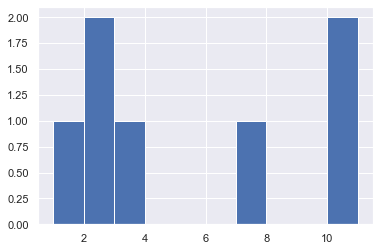

In [294]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skew, kurtosis

# Сгенерируем случайные данные
# data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(4, 1, 1000)])
x = np.array([1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1])
data = np.repeat(np.arange(1, x.size + 1), x.astype(int))

plt.hist(data)
sk = skew(data)
ku = kurtosis(data)
n = data.size

BC = (sk**2 + 1) / (ku + 3*((n - 1)**2 / ((n - 2) * (n - 3))))
print("BC:", BC)
print("diptest:", diptest.dipstat(data))
# # Построим гистограмму
# plt.hist(data, bins=30)

# print(max_width_peaks(np.histogram(data, bins=30)[0]))

In [153]:
peaks

array([2, 7], dtype=int64)

In [ ]:
[0.75243317 0.07333642 0.13933905 0.8614329  0.74303577 0.52134847
 0.72960017]

In [ ]:
[0.74996573 0.07691214 0.14588498 0.85021201 0.74433642 0.52095168
 0.73079795]

In [ ]:
[0.76422207 0.06826685 0.13153203 0.89333202 0.75438083 0.53143861
 0.74086918]

[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]

In [ ]:
[0.75668266 0.07506964 0.13524413 0.80499555 0.74893613 0.52512688
 0.73537194]

[0.75695682 0.07440272 0.14538163 0.85218725 0.74779245 0.52774081
 0.73445599]

In [ ]:
[0.75791638 0.07364925 0.13941104 0.84413016 0.74317018 0.52911454
 0.73019711]

[0.76004112 0.0753898  0.14509276 0.83574934 0.74281228 0.52814724
 0.72980227]

In [ ]:
[0.77930089 0.07105522 0.13704887 0.85401808 0.7516657  0.52669224
 0.73803095]

In [ ]:
[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]



In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]
[0.7540096  0.07487264 0.13640897 0.87782645 0.74885486 0.52464159
 0.73526618]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]

In [ ]:
[0.7540096  0.07479226 0.13625052 0.87836153 0.74900861 0.52494637
 0.73542908]

In [ ]:
[0.74002742 0.07227528 0.13196277 0.86458745 0.74718982 0.52254975
 0.73357527]

In [ ]:
[0.75531186 0.07359772 0.14559497 0.85845047 0.74459797 0.52122024
 0.73105993]

In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62802423 0.14211188 0.34170921 0.75739075 0.69467389 0.51757682
 0.67461211]

In [ ]:
[0.63107289 0.14144822 0.3462126  0.77005228 0.6896938  0.51910505
 0.67036929]

In [ ]:
[0.63056478 0.14079638 0.34322143 0.76938389 0.69300919 0.51992004
 0.67340143]

In [ ]:
[0.63146375 0.14081558 0.34032002 0.76382246 0.6913002  0.51914928
 0.67179873]

In [ ]:
[0.62364667 0.14340442 0.34647329 0.77301765 0.69317095 0.51897566
 0.67343789]

In [ ]:
[0.63306625 0.13905343 0.37198661 0.78508546 0.68627601 0.52907648
 0.66846826]

In [ ]:
[0.6214188  0.14391302 0.35822151 0.76261641 0.68925319 0.51655777
 0.66969004]

In [ ]:
[0.63162009 0.14071645 0.34137235 0.76280546 0.69149669 0.51923545
 0.67198272]